#### Importing various modules and libraries for data manipulation, transformation, plotting, modelling and metrix calculating

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import layers, models

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import optimizers
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import LearningRateScheduler

import time

#### Downloaded EMNIST dataset from Kaggle and loading the dataset from the CSV using Pandas

In [2]:
train_df = pd.read_csv("emnist-balanced-train.csv", header=None)
test_df = pd.read_csv("emnist-balanced-test.csv", header=None)

# Splitting the features and labels
X_train, y_train = train_df.iloc[:, 1:], train_df.iloc[:, 0]
X_test, y_test = test_df.iloc[:, 1:], test_df.iloc[:, 0]
print("Training dataset shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Training dataset shape:", X_test.shape)
print("Training labels shape:", y_test.shape)

Training dataset shape: (112800, 784)
Training labels shape: (112800,)
Training dataset shape: (18800, 784)
Training labels shape: (18800,)


#### Extracting pixels from features

In [3]:
x_train = train_df.drop(columns=[0]).values
y_train = train_df[0].values
x_test = test_df.drop(columns=[0]).values
y_test = test_df[0].values

# Reshaping training dataset
x_train = x_train.reshape((-1, 28, 28))  
print("Training dataset shape after reshaping:", x_train.shape)

# Reshaping testing dataset
x_test = x_test.reshape((-1, 28, 28))
print("Testing dataset shape after reshaping:", x_test.shape)

Training dataset shape after reshaping: (112800, 28, 28)
Testing dataset shape after reshaping: (18800, 28, 28)


In [4]:
NUM_CLASSES = 47  # Number of classes in EMNIST dataset
BATCH_SIZE = 64  
NUM_EPOCHS = 10
IMAGE_SHAPE = (28, 28, 1)

#### Visualizing the Images from the pixels

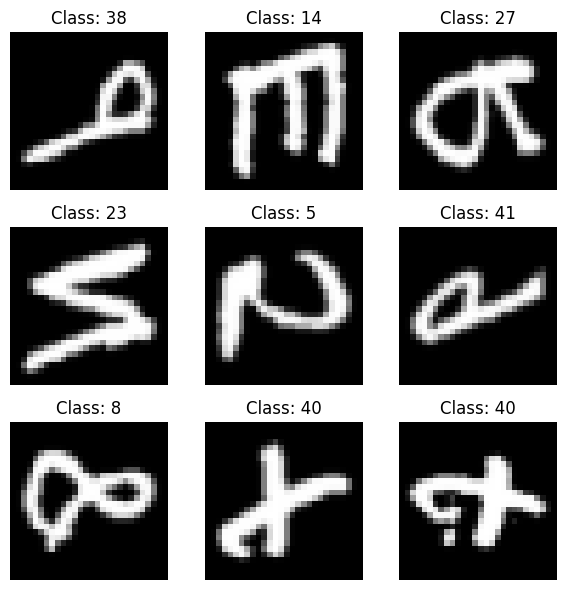

In [5]:
def visualize_dataset(images, labels, num_samples=9):
    """
    To visualize random images form the training dataset
    """
    sample_indices = np.random.choice(len(images), size=num_samples, replace=False)
    plt.figure(figsize=(6, 6))
    for i, index in enumerate(sample_indices):
        image = images[index]
        label = labels[index]
        plt.subplot(3, 3, i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f"Class: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_dataset(x_train, y_train)

### 2. Creating a MLP for predicting the images

#### Baseline MLP Model to test the model with default hyperparameters

In [6]:
def baseline_mlp_model():
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))
    
    # Hidden layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.001)))
    
    # Output layer
    model.add(layers.Dense(47, activation='softmax'))
    
    return model

base_mlp_model = baseline_mlp_model()
base_mlp_model.summary()

c:\Users\logan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,567 (482.68 KB)

 Trainable params: 123,311 (481.68 KB)

 Non-trainable params: 256 (1.00 KB)

In [7]:
base_mlp_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Train the model
mlp_history = base_mlp_model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

# Evaluate the model on the test dataset
test_loss, test_accuracy = base_mlp_model.evaluate(x_test, y_test, verbose=1)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4516 - loss: 2.9675 - val_accuracy: 0.7233 - val_loss: 1.3236
Epoch 2/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6626 - loss: 1.4957 - val_accuracy: 0.7552 - val_loss: 1.0917
Epoch 3/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6938 - loss: 1.2934 - val_accuracy: 0.7720 - val_loss: 0.9882
Epoch 4/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7101 - loss: 1.2036 - val_accuracy: 0.7846 - val_loss: 0.9290
Epoch 5/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7209 - loss: 1.1567 - val_accuracy: 0.7898 - val_loss: 0.8859
Epoch 6/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7283 - loss: 1.1148 - val_accuracy: 0.7949 - val_loss: 0.8671
Epoch 7/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7344 - loss: 1.0891 - val_accuracy: 0.7975 - val_loss: 0.8564
Epoch 8/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7379 - loss: 1.0738 - 

#### Creating the best MLP by cross validation of various hyperparameter

In [8]:
def best_mlp_model(activation_func='relu', use_batch_norm=False, use_dropout=False, use_l1_regularization=False, use_l2_regularization=False):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))
    
    # Adding hidden layers
    model.add(layers.Dense(128, activation=activation_func))
    if use_batch_norm:
        model.add(layers.BatchNormalization())
    if use_dropout:
        model.add(layers.Dropout(0.5))
    if use_l1_regularization:
        model.add(layers.Dense(128, activation=activation_func, kernel_regularizer=tf.keras.regularizers.l1(0.001)))
    elif use_l2_regularization:
        model.add(layers.Dense(128, activation=activation_func, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    else:
        model.add(layers.Dense(128, activation=activation_func))
    
    # Output layer
    model.add(layers.Dense(47, activation='softmax'))
    
    return model

def lr_schedule(epoch):
    return 0.001 * np.exp(-epoch / 10.0)

# The parameters for exploration
activation_functions = ['relu', 'leaky_relu', 'elu']
optimizers = {'SGD': SGD, 'Adam': Adam, 'RMSprop': RMSprop}
use_batch_norm_options = [True, False]
use_dropout_options = [True, False]
use_l1_regularization_options = [True, False]
use_l2_regularization_options = [True, False]

# The number of folds
k_folds = 3

# Splitting the dataset into k folds
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initializing variables to store the best configuration
best_accuracy = 0
best_config = None
best_training_time = float('inf')

for fold, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):
    print(f"Fold {fold + 1}/{k_folds}")
    
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    for activation_func in activation_functions:
        for optimizer_name, optimizer_instance in optimizers.items():
            for use_batch_norm in use_batch_norm_options:
                for use_dropout in use_dropout_options:
                    for use_l1_regularization in use_l1_regularization_options:
                        for use_l2_regularization in use_l2_regularization_options:
                            start_time = time.time()
                            
                            mlp_model = best_mlp_model(activation_func=activation_func, 
                                                         use_batch_norm=use_batch_norm, 
                                                         use_dropout=use_dropout, 
                                                         use_l1_regularization=use_l1_regularization, 
                                                         use_l2_regularization=use_l2_regularization)
                            
                            optimizer = optimizer_instance()
                            
                            mlp_model.compile(optimizer=optimizer,
                                              loss='sparse_categorical_crossentropy',
                                              metrics=['accuracy'])
                            
                            history = mlp_model.fit(x_train_fold, y_train_fold, epochs=10, batch_size=64, 
                                                    validation_data=(x_val_fold, y_val_fold), callbacks=[LearningRateScheduler(lr_schedule)])
                            
                            test_loss, test_accuracy = mlp_model.evaluate(x_test, y_test)
                            
                            # Record end time
                            end_time = time.time()
                            training_time = end_time - start_time
                            
                            # Check if current configuration achieved higher accuracy
                            if test_accuracy > best_accuracy:
                                best_accuracy = test_accuracy
                                best_config = {
                                    'Activation Function': activation_func,
                                    'Optimizer': optimizer_name,
                                    'Batch Norm': use_batch_norm,
                                    'Dropout': use_dropout,
                                    'L1 Reg': use_l1_regularization,
                                    'L2 Reg': use_l2_regularization,
                                    'Test Accuracy': test_accuracy,
                                    'Training Time': training_time
                                }
                            # Check if current configuration has the shortest training time
                            if training_time < best_training_time:
                                best_training_time = training_time

# Print the best configuration
print("Best Configuration:")
print(best_config)

# {'Activation Function': 'elu', 'Optimizer': 'Adam', 'Batch Norm': True, 'Dropout': False, 'L1 Reg': False, 'L2 Reg': False, 
# 'Test Accuracy': 0.8473404049873352, 'Training Time': 91.47691035270691}
# {'Activation Function': 'elu', 'Optimizer': 'RMSprop', 'Batch Norm': True, 'Dropout': False, 'L1 Reg': False, 'L2 Reg': True, 
# 'Test Accuracy': 0.8383510708808899, 'Training Time': 26.161000728607178}


#### Creating a test MLP model, this time fitting the best hyperparameters which gave the best accuracy.

In [9]:
def mlp_test_model(activation_func='elu', use_batch_norm=False, use_dropout=False, use_l1_regularization=False, use_l2_regularization=False):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28)))
    
    # Add hidden layers
    model.add(layers.Dense(128, activation=activation_func))
    if use_batch_norm:
        model.add(layers.BatchNormalization())
    if use_dropout:
        model.add(layers.Dropout(0.5))
    if use_l1_regularization:
        model.add(layers.Dense(128, activation=activation_func, kernel_regularizer=tf.keras.regularizers.l1(0.001)))
    elif use_l2_regularization:
        model.add(layers.Dense(128, activation=activation_func, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    else:
        model.add(layers.Dense(128, activation=activation_func))
    
    # Output layer
    model.add(layers.Dense(47, activation='softmax'))
    
    return model

# Best hyperparameters
best_config = {
    'Activation Function': 'elu',
    'Optimizer': 'RMSprop',
    'Batch Norm': True,
    'Dropout': False,
    'L1 Reg': False,
    'L2 Reg': True,
}

# Creating the MLP model using the best hyperparameters which were obtained above.
# I couldn't run again the whole hypertesting because of time constraints but I have printed above the best hyperparameters with total time taken.
mlp_test = mlp_test_model(
    activation_func=best_config['Activation Function'],
    use_batch_norm=best_config['Batch Norm'],
    use_dropout=best_config['Dropout'],
    use_l1_regularization=best_config['L1 Reg'],
    use_l2_regularization=best_config['L2 Reg']
)

# Compiling the model
mlp_test.compile(optimizer=best_config['Optimizer'],
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

mlp_test.summary()

history_mlp_test = mlp_test.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the model on the test dataset
test_loss_mlp_best, test_accuracy_mlp_best = mlp_test.evaluate(x_test, y_test)
print("Test Accuracy:", test_accuracy_mlp_best)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,567 (482.68 KB)

 Trainable params: 123,311 (481.68 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6189 - loss: 1.4880 - val_accuracy: 0.7803 - val_loss: 0.8024
Epoch 2/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7933 - loss: 0.7565 - val_accuracy: 0.8045 - val_loss: 0.6807
Epoch 3/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8184 - loss: 0.6412 - val_accuracy: 0.8105 - val_loss: 0.6438
Epoch 4/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8315 - loss: 0.5808 - val_accuracy: 0.8151 - val_loss: 0.6218
Epoch 5/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8384 - loss: 0.5470 - val_accuracy: 0.8273 - val_loss: 0.5811
Epoch 6/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8462 - loss: 0.5200 - val_accuracy: 0.8286 - val_loss: 0.5745
Epoch 7/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8509 - loss: 0.4990 - val_accuracy: 0.8301 - val_loss: 0.5641
Epoch 8/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8550 - loss: 0.4837 - 

In [10]:
def calculate_scores(model, x, y_true):
    """
    Calculating F1 score and recall

    """
    y_pred = model.predict(x)
    
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    
    return f1, recall

#### Calculating f1 and recall of the model

In [11]:
# Calculating F1 score and recall for MLP model
mlp_f1, mlp_recall = calculate_scores(mlp_test, x_test, y_test)

print("MLP Model - F1 Score:", mlp_f1)
print("MLP Model - Recall Score:", mlp_recall)

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step
MLP Model - F1 Score: 0.8303301090859602
MLP Model - Recall Score: 0.8325


#### Plotting the images to compare true and predicted labels from the test MLP model

In [12]:
# Mapping from numerical labels to characters. Found along with the dataset on kaggle.
label_mapping = {
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
    20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
    30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e',
    40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'
}

In [13]:
# Function to visualise the true and pridicted label after creating the best model
def visualize_samples(images, true_labels, predicted_labels=None):
    """
    To visualize the samples with true and predicted lables for CNN and MLP
    """
    num_samples = len(images)
    num_cols = 3
    num_rows = np.ceil(num_samples / num_cols).astype(int)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))
    
    for i, ax in enumerate(axes.flat):
        if i < num_samples:
            ax.imshow(images[i].squeeze(), cmap='gray')
            ax.set_title(f"True: {label_mapping[true_labels[i]]}")
            
            if predicted_labels is not None:
                ax.set_title(f"True: {label_mapping[true_labels[i]]}\nPredicted: {label_mapping[predicted_labels[i]]}")
            
            ax.axis('off')
        else:
            ax.axis('off')
    
    fig.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


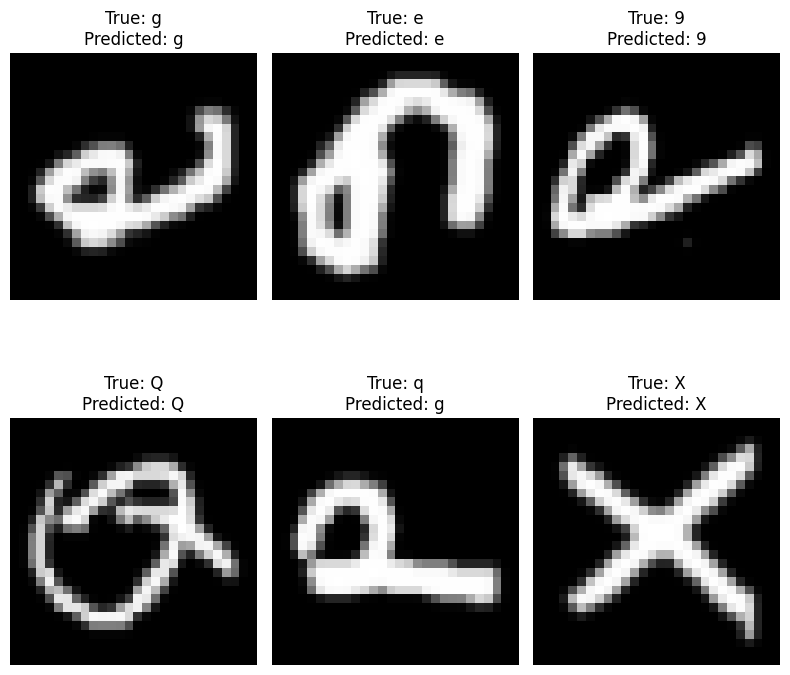

In [14]:
mlp_sample_indices = np.arange(6)
mlp_sample_images = x_test[mlp_sample_indices]
mlp_sample_labels = y_test[mlp_sample_indices]

# Predicting the labels for the samples using the trained MLP model
predictions = mlp_test.predict(mlp_sample_images)
predicted_labels = np.argmax(predictions, axis=1)

visualize_samples(mlp_sample_images, mlp_sample_labels, predicted_labels)

#### Potting the training & validation accuracy || Plotting training & validation loss values

In [15]:
def plot_model_metrics(history, model_type):
    """
    Plot training and validation accuracy and loss values for MLP or CNN model.
    
    """
    plt.figure(figsize=(10, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation', color='orange')
    plt.title(f'{model_type} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train', color='blue')
    plt.plot(history.history['val_loss'], label='Validation', color='orange')
    plt.title(f'{model_type} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

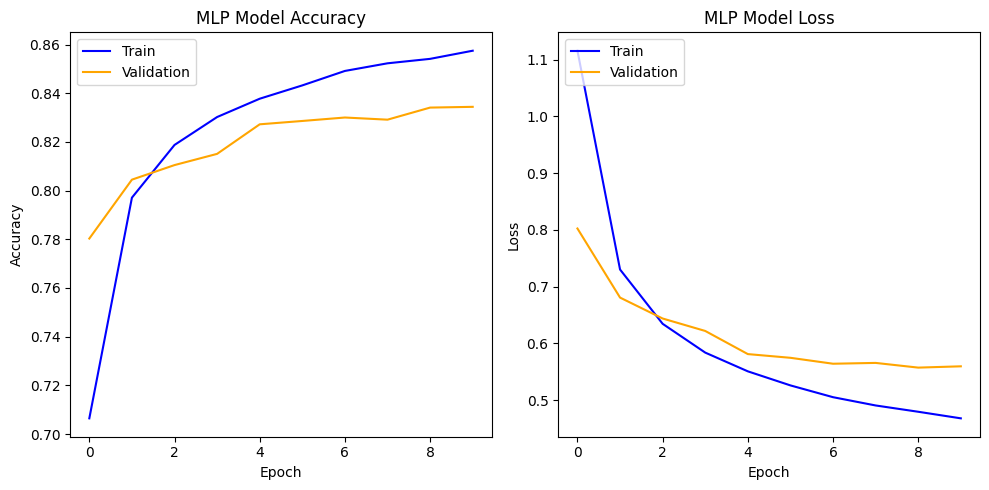

In [16]:
plot_model_metrics(history_mlp_test, 'MLP')

#### Plotting the confusion matrix with a classification report

588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step


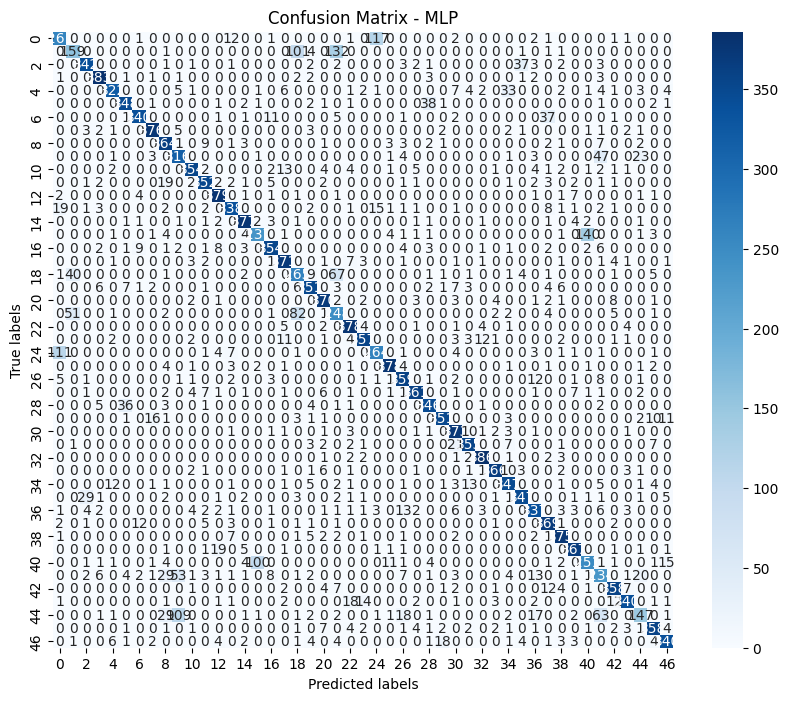

Classification Report - MLP:

              precision    recall  f1-score   support

           0       0.64      0.65      0.65       400
           1       0.63      0.40      0.49       400
           2       0.89      0.85      0.87       400
           3       0.93      0.96      0.94       400
           4       0.92      0.81      0.86       400
           5       0.87      0.87      0.87       400
           6       0.92      0.85      0.88       400
           7       0.93      0.94      0.93       400
           8       0.77      0.91      0.83       400
           9       0.64      0.79      0.71       400
          10       0.93      0.89      0.91       400
          11       0.90      0.88      0.89       400
          12       0.89      0.95      0.92       400
          13       0.89      0.84      0.87       400
          14       0.92      0.94      0.93       400
          15       0.69      0.59      0.64       400
          16       0.90      0.89      0.89       4

In [17]:
def plot_metrics(model, x_test, y_test, model_type):
    """
    Function to plot the consudion matrix of the labels
    """
    # Predict probabilities for the test set
    y_pred_probs = model.predict(x_test)
    
    # Convert probabilities to predicted classes
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {model_type}')
    plt.show()

    # Calculate classification report
    print(f"Classification Report - {model_type}:\n")
    print(classification_report(y_test, y_pred))

# Plot metrics for MLP model
plot_metrics(mlp_test, x_test, y_test, model_type='MLP')

### 2. Creating a CNN for predicting the images

#### Baseline CNN Model to test the model with default hyperparameters

In [18]:
def baseline_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=IMAGE_SHAPE),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu', kernel_regularizer=l1(0.001)),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Instantiate the baseline CNN model
baseline_cnn_model = baseline_cnn_model()

# Print model summary
baseline_cnn_model.summary()

# Train the baseline CNN model
baseline_history = baseline_cnn_model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the model on the test dataset
test_loss, test_accuracy = baseline_cnn_model.evaluate(x_test, y_test)
print("Test Accuracy:", test_accuracy)

c:\Users\logan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       346,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 47)             │         3,055 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 349,551 (1.33 MB)

 Trainable params: 349,551 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.0224 - loss: 7.2690 - val_accuracy: 0.0392 - val_loss: 4.1408
Epoch 2/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.1724 - loss: 3.5935 - val_accuracy: 0.7326 - val_loss: 1.3549
Epoch 3/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7482 - loss: 1.2754 - val_accuracy: 0.7672 - val_loss: 1.0881
Epoch 4/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7794 - loss: 1.0678 - val_accuracy: 0.7801 - val_loss: 1.0592
Epoch 5/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7892 - loss: 1.0141 - val_accuracy: 0.7726 - val_loss: 1.0429
Epoch 6/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7946 - loss: 1.0002 - val_accuracy: 0.7816 - val_loss: 1.0038
Epoch 7/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7966 - loss: 0.9818 - val_accuracy: 0.7954 - val_loss: 0.9746
Epoch 8/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7991 - loss: 0.9695 - 

#### Building a CNN model with three convolution layers and 64 neurons, which takes default parameters and later passed different hyperparameters for testing when the model is being called.

In [19]:
# Creating CNN with the defaults hyperparameters
def improved_cnn_model(activation_func='relu', optimizer='adam', use_batch_norm=False, use_dropout=False, use_l1_regularization=False, use_l2_regularization=False):
    model = models.Sequential()
    
    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation=activation_func, input_shape=IMAGE_SHAPE))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation=activation_func))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation=activation_func))
    model.add(layers.Flatten())
    
    # Fully connected layers
    model.add(layers.Dense(64, activation=activation_func))
    
    if use_batch_norm:
        model.add(layers.BatchNormalization())
    
    if use_dropout:
        model.add(layers.Dropout(0.5))
    
    # Output layer
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
    
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001)
def lr_schedule(epoch):
    """
    Learning rate schedule function.
    """
    learning_rate = 0.001 * np.exp(-epoch / 10.0)
    return learning_rate

# Defining the hyperparameters for exploration
# activation_functions = ['relu', 'leaky_relu', 'elu']
# optimizers = {'SGD': SGD(), 'Adam': Adam(), 'RMSprop': RMSprop()}
# use_batch_norm_options = [True, False]
# use_dropout_options = [True, False]
# use_l1_regularization_options = [True, False]
# use_l2_regularization_options = [True, False]


#### In the following code block, I'm testing out the best hyperparameter with cross validation of k folds = 3, and then passing the hyperparamters in each for loop

#### Testing out the hyperparameters and comparing with the baseline CNN model

In [20]:
# Define the number of folds for Cross Validation
k_folds = 3

# Split the dataset into k folds
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

activation_functions = ['relu', 'leaky_relu', 'elu']
optimizers = {'SGD': SGD, 'Adam': Adam, 'RMSprop': RMSprop}
use_batch_norm_options = [True, False]
use_dropout_options = [True, False]
use_l1_regularization_options = [True, False]
use_l2_regularization_options = [True, False]

# Define a function to create and compile the CNN model
def create_and_compile_model(activation_func, use_batch_norm, use_dropout, use_l1_regularization, use_l2_regularization, optimizer):
    cnn_model = improved_cnn_model(activation_func=activation_func, 
                                           use_batch_norm=use_batch_norm, 
                                           use_dropout=use_dropout, 
                                           use_l1_regularization=use_l1_regularization, 
                                           use_l2_regularization=use_l2_regularization)
    cnn_model.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return cnn_model

# Loop over each fold
for fold, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):
    print(f"Fold {fold + 1}/{k_folds}")
    
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Initializing variables to store the best configuration and its corresponding performance
    best_accuracy = 0
    best_config = None
    best_training_time = float('inf')
    
    for activation_func in activation_functions:
        for optimizer_name, optimizer_class in optimizers.items():
            for use_batch_norm in use_batch_norm_options:
                for use_dropout in use_dropout_options:
                    for use_l1_regularization in use_l1_regularization_options:
                        for use_l2_regularization in use_l2_regularization_options:

                            # Record start time
                            start_time = time.time()
                            
                            # Creating and compile the CNN model
                            cnn_model = create_and_compile_model(activation_func, 
                                                                 use_batch_norm, 
                                                                 use_dropout, 
                                                                 use_l1_regularization, 
                                                                 use_l2_regularization, 
                                                                 optimizer_class())  # Create new optimizer instance
                            
                            # Training the model
                            history = cnn_model.fit(x_train_fold, y_train_fold, epochs=10, batch_size=64, 
                                                    validation_data=(x_val_fold, y_val_fold), callbacks=[LearningRateScheduler(lr_schedule)])
                            
                            # Evaluating the model
                            test_loss, test_accuracy = cnn_model.evaluate(x_test, y_test)
                            
                            # Recording end time
                            end_time = time.time()
                            training_time = end_time - start_time
                            
                            # Checking if current configuration achieved higher accuracy
                            if test_accuracy > best_accuracy:
                                best_accuracy = test_accuracy
                                best_config = {
                                    'Activation Function': activation_func,
                                    'Optimizer': optimizer_name,
                                    'Batch Norm': use_batch_norm,
                                    'Dropout': use_dropout,
                                    'L1 Reg': use_l1_regularization,
                                    'L2 Reg': use_l2_regularization,
                                    'Test Accuracy': test_accuracy,
                                    'Training Time': training_time
                                }
                            # Checking if current configuration has the shortest training time
                            if training_time < best_training_time:
                                best_training_time = training_time
    
    # Printing the best configuration for this fold
    print("Best Configuration for Fold", fold + 1, ":", best_config)

    # Accuracy without CV
    # {'Activation Function': 'relu', 'Optimizer': 'RMSprop', 'Batch Norm': True, 'Dropout': False, 'L1 Reg': True, 'L2 Reg': False, 
    # 'Test Accuracy': 0.8885638117790222, 'Training Time': 172.49939727783203}
    
    # Accuracy with CV
    # {'Activation Function': 'elu', 'Optimizer': 'RMSprop', 'Batch Norm': True, 'Dropout': True, 'L1 Reg': False, 'L2 Reg': True, 
    # 'Test Accuracy': 0.8835106492042542, 'Training Time': 154.21594667434692}

#### Creating a baseline CNN model, again, this time fitting the best hyperparameters and 3 hidden layers which gave the best accuracy

In [21]:
def testing_cnn_model(best_config):
    model = models.Sequential()
    
    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation=best_config['Activation Function'], input_shape=IMAGE_SHAPE))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation=best_config['Activation Function']))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation=best_config['Activation Function']))
    model.add(layers.Flatten())
    
    # Fully connected layers
    model.add(layers.Dense(64, activation=best_config['Activation Function']))
    
    if best_config['Batch Norm']:
        model.add(layers.BatchNormalization())
    
    if best_config['Dropout']:
        model.add(layers.Dropout(0.5))
    
    # Output layer
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
    
    model.compile(optimizer=best_config['Optimizer'],
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Obtrained from the hyperparameter training
# Creating the CNN model using the best hyperparameters which were obtained above.
# I couldn't run again the whole hypertesting because of time constraints but I have printed above 
# the best hyperparameters with total time taken.
best_config = {
    'Activation Function': 'elu',
    'Optimizer': 'RMSprop',
    'Batch Norm': True,
    'Dropout': True,
    'L1 Reg': False,
    'L2 Reg': True
}

# Create the improved CNN model using the best hyperparameters
testing_cnn_model = testing_cnn_model(best_config)
testing_cnn_model.summary()

# Train the model
cnn_test_history = testing_cnn_model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the model on the test dataset
test_loss, test_accuracy = testing_cnn_model.evaluate(x_test, y_test)
print("Test Accuracy:", test_accuracy)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 47)             │         3,055 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,983 (374.93 KB)

 Trainable params: 95,855 (374.43 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.4911 - loss: 1.9674 - val_accuracy: 0.8055 - val_loss: 0.6119
Epoch 2/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7937 - loss: 0.6486 - val_accuracy: 0.8528 - val_loss: 0.4329
Epoch 3/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8253 - loss: 0.5333 - val_accuracy: 0.8620 - val_loss: 0.3955
Epoch 4/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8426 - loss: 0.4835 - val_accuracy: 0.8556 - val_loss: 0.4159
Epoch 5/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8515 - loss: 0.4554 - val_accuracy: 0.8711 - val_loss: 0.3862
Epoch 6/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8582 - loss: 0.4288 - val_accuracy: 0.8748 - val_loss: 0.3850
Epoch 7/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8622 - loss: 0.4058 - val_accuracy: 0.8750 - val_loss: 0.3978
Epoch 8/10
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8658 - loss: 0

#### Calculating f1 and recall of the model

In [22]:

# Calculating F1 score and recall for CNN model
cnn_f1, cnn_recall = calculate_scores(testing_cnn_model, x_test, y_test)

print("CNN Model - F1 Score:", cnn_f1)
print("CNN Model - Recall Score:", cnn_recall)

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CNN Model - F1 Score: 0.8753725607137547
CNN Model - Recall Score: 0.877127659574468


#### Plotting the images to compare true and predicted labels from the improved cnn model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


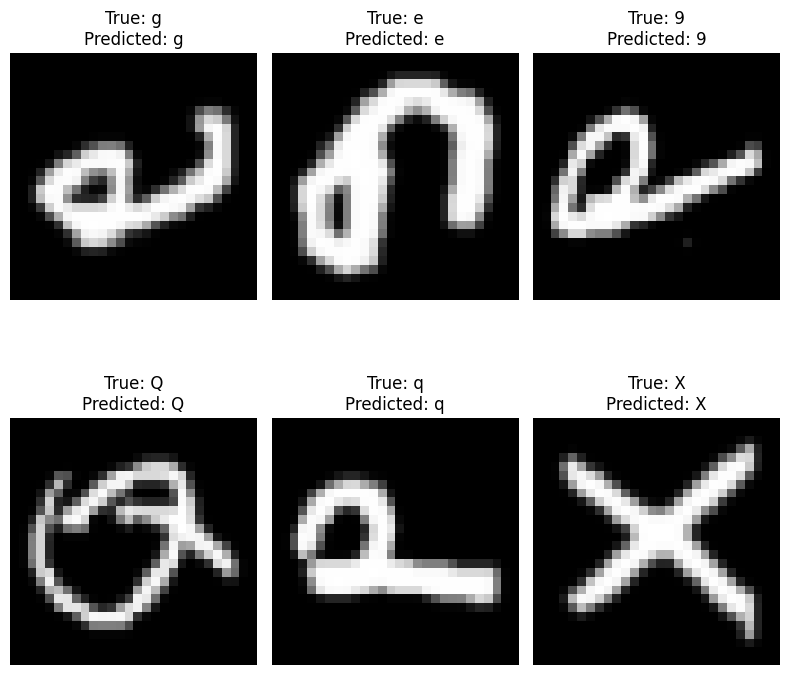

In [23]:
cnn_sample_indices = np.arange(6)
sample_images = x_test[cnn_sample_indices]
sample_labels = y_test[cnn_sample_indices]

# Predicting the labels for the samples using the trained CNN model
predictions = testing_cnn_model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)

visualize_samples(sample_images, sample_labels, predicted_labels)

#### Potting the training & validation accuracy || Plotting training & validation loss values

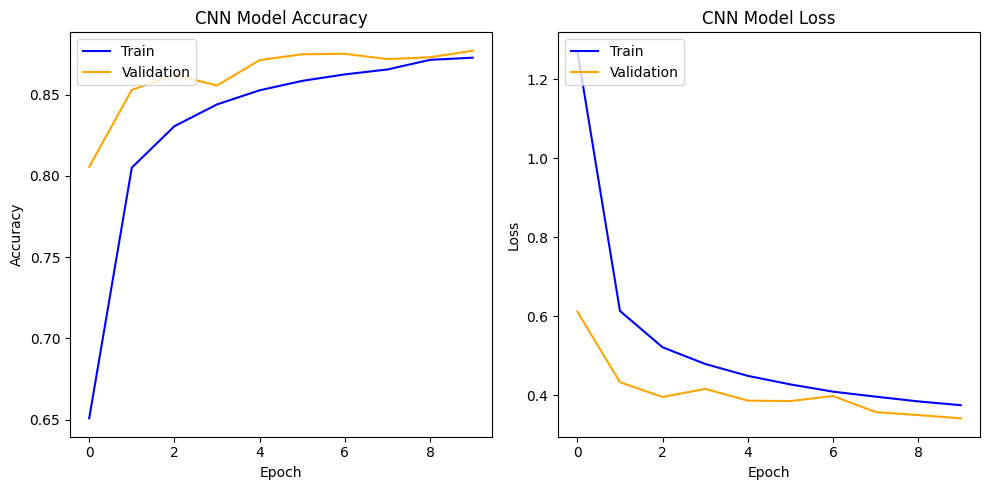

In [24]:
plot_model_metrics(cnn_test_history, 'CNN')

#### Plotting the confusion matrix with a classification report

588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


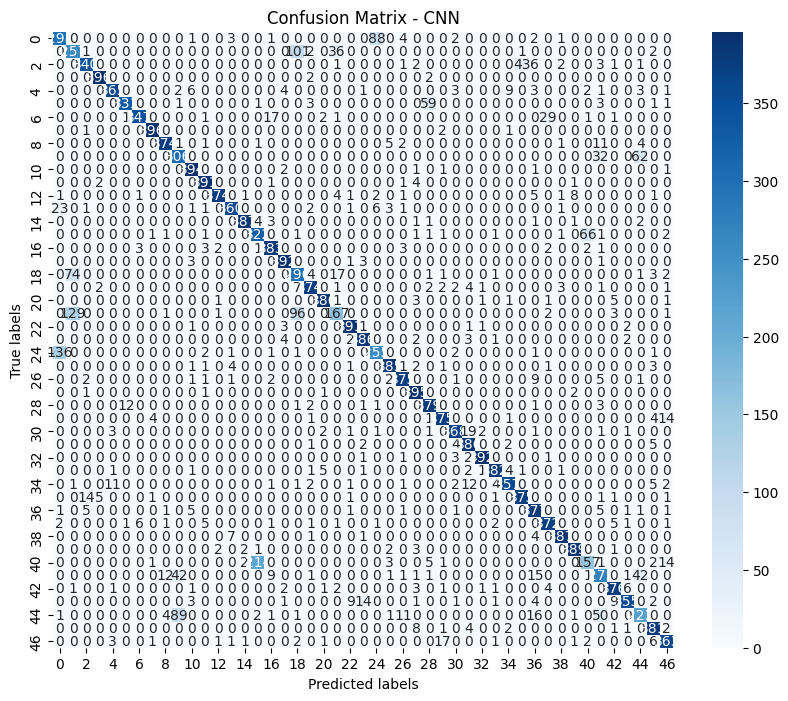

Classification Report - CNN:

              precision    recall  f1-score   support

           0       0.65      0.74      0.69       400
           1       0.56      0.64      0.60       400
           2       0.93      0.85      0.89       400
           3       0.98      0.99      0.98       400
           4       0.95      0.91      0.93       400
           5       0.96      0.83      0.89       400
           6       0.97      0.87      0.92       400
           7       0.98      0.99      0.99       400
           8       0.95      0.94      0.94       400
           9       0.69      0.77      0.73       400
          10       0.94      0.98      0.96       400
          11       0.96      0.98      0.97       400
          12       0.98      0.94      0.96       400
          13       0.95      0.90      0.93       400
          14       0.98      0.97      0.98       400
          15       0.59      0.81      0.68       400
          16       0.91      0.96      0.93       4

In [25]:
# Plotting metrics for CNN model
plot_metrics(testing_cnn_model, x_test, y_test, model_type='CNN')